# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408905728, available=520684834816, percent=3.6, used=14942089216, free=522104844288, active=1665978368, inactive=7566770176, buffers=3833856, cached=3358138368, shared=1772019712, slab=1319976960)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [5]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [6]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [7]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [8]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [9]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [10]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [5]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [6]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

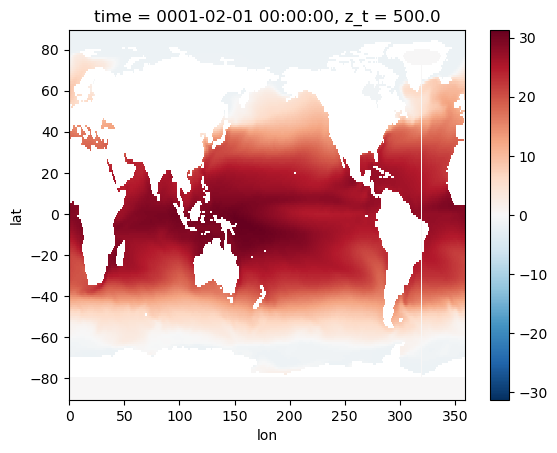

In [7]:
ds_tos.isel(time=0).plot()

## Subset data

In [8]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [9]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

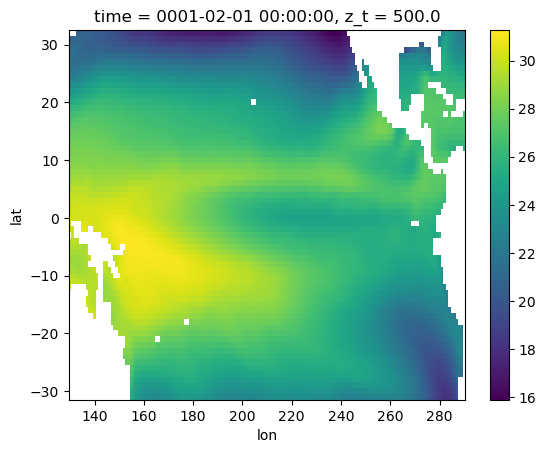

In [10]:
S_tos.isel(time=0).plot()

In [11]:
del(ds_tos, ds_ssh)

In [12]:
import psutil
psutil.virtual_memory() 

svmem(total=540408905728, available=520463572992, percent=3.7, used=15163035648, free=521883275264, active=1666007040, inactive=7786176512, buffers=3833856, cached=3358760960, shared=1772023808, slab=1320775680)

## Create matrices, de-trending data and anomalies

In [13]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [14]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
del(S_tos,S_ssh)

In [16]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [17]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [18]:
del(X_ssh)

# Evaluation

### Tools for the plots

In [19]:
import nc_time_axis

In [20]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [21]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

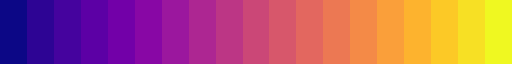

In [22]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [23]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [24]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

# ALL GAUSS 400

### Prepare data

In [25]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [26]:
tot_for=np.zeros((20, 7, 1845, 24, 1176))

In [27]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

In [28]:
tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [29]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [30]:
del(tot_for)

In [31]:
tot_for_union.shape

(7, 1845, 24, 24000)

In [32]:
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [33]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [34]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 4))

In [36]:
#for n in lead_times:
for lead in range(10,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:845,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 4):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:845,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

10    0.42762368657377986     0.34149685063310226
11    0.4020557420481924     0.3157618217107754
12    0.377293709691573     0.2913310078930531
13    0.3540373481724104     0.26888319534908456
14    0.3320089224559406     0.2479544340398498
15    0.30969239580344426     0.22763202271135266
16    0.28952366178453126     0.20910266908918157
17    0.2684157183290639     0.19081129375897174
18    0.24950631579038426     0.17509351775254725
19    0.23082000282088913     0.15943385409551672
20    0.21361512787657666     0.14498767541791696
21    0.19613884718856667     0.1310173879195671
22    0.1790079291231846     0.11781282804469417
23    0.16543843881559464     0.10730803206857593


In [41]:
np.save('Other skill metrics/ALLGAUSS_400_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/ALLGAUSS_400_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# 30 GAUSS 400

### Prepare data

In [24]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [25]:
tot_for=np.zeros((20, 7, 30, 24, 1176))

In [26]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/30EOFs_forecast_p{n}.npy')

In [27]:
tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [28]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [29]:
del(tot_for)

In [30]:
tot_for_union.shape

(7, 30, 24, 24000)

In [31]:
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [32]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [33]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 4))

In [34]:
mean_av.shape

(23976, 24)

In [50]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 4):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:20,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

0    0.8858384111440224     0.885227218443371
1    0.7122846132804218     0.619508949307834
2    0.6158283921763018     0.5134589446077864
3    0.5700479002704361     0.4678521159357666
4    0.5352378219938354     0.4330761443969524
6    0.4744892129884336     0.37373995186346515
7    0.4453178448148978     0.34519603652834296
8    0.41921069327314203     0.32019147182506524
9    0.39369051103920727     0.2963410331171128
10    0.36955231075777445     0.2739505936578151
11    0.3473921715292654     0.2538919684083557
12    0.32487208129004297     0.23318639479302777
13    0.30280122179798835     0.21443435092049756
14    0.28251869849913275     0.1972339038936231
15    0.26206535292932603     0.18052443722044723
16    0.24440796172926213     0.1657027563691667
17    0.22628696163738554     0.15125713153267956
18    0.2098257161284488     0.13823633104702318
19    0.1964532492574566     0.12746532854809134
20    0.1819336584481034     0.11600841147074124
21    0.16584654855045358     0.

In [51]:
np.save('Other skill metrics/30GAUSS_400_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/30GAUSS_400_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# 30 POLY 400

### Prepare data

In [54]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [55]:
tot_for=np.zeros((20, 7, 30, 24, 1176))

In [56]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

In [57]:
tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [58]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [59]:
del(tot_for)

In [60]:
tot_for_union.shape

(7, 30, 24, 24000)

In [61]:
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [62]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [63]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 4))

In [64]:
mean_av.shape

(23976, 24)

In [65]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 4):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:20,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

0    0.8865138574721565     0.8865138574721564
1    0.7778900358062986     0.777282642264803
2    0.681269695437599     0.6796197687161859
3    0.6195301197837426     0.6168877611071308
4    0.5735792211984063     0.5701080728394746
5    0.535475692698474     0.5313393797324585
6    0.5003799467697008     0.4957165272086075
7    0.46698999242630346     0.4618987468636271
8    0.4354529196978483     0.43000348943256217
9    0.4056389800947485     0.39988162544425915
10    0.37706077272274846     0.3710686789132293
11    0.35005210933244657     0.3438814403500367
12    0.32483305583843924     0.3185716445065156
13    0.30182932460899725     0.29551778480871715
14    0.2811149518799997     0.27477300075450917
15    0.26182165499169513     0.2555623636071031
16    0.24403368063893968     0.23790453213351898
17    0.22776412862345657     0.22169398946003704
18    0.21285840857748323     0.20691567145450288
19    0.19956096817317326     0.19365290207131575
20    0.18723187865968532     0.181

In [66]:
np.save('Other skill metrics/POLY_400_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/POLY_400_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# ALL GAUSS 200

### Prepare data

In [26]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [27]:
tot_for=np.zeros((20, 17, 1845, 24, 1176))

In [28]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

In [29]:
tot_for_union=np.empty((17, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [30]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [31]:
del(tot_for)

In [32]:
tot_for_union.shape

(17, 1845, 24, 24000)

In [33]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [34]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [35]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 9))

In [36]:
#for n in lead_times:
for lead in range(19,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:845,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 9):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:845,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

19    0.2546473805945243     0.1506214692762996
20    0.23799872246364712     0.13709984984387308
21    0.22070746488905246     0.12384061022503878
22    0.20320601528984386     0.11102956744463864
23    0.18995395089536404     0.10121148256394068


In [73]:
np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation', memb200, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation_ind', Ind200, allow_pickle=True, fix_imports=True)

# 30 GAUSS 200

### Prepare data

In [25]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [26]:
tot_for=np.zeros((20, 17, 30, 24, 1176))

In [27]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/30EOFs_forecast_p{n}.npy')

In [28]:
tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [29]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [30]:
del(tot_for)

In [31]:
tot_for_union.shape

(17, 30, 24, 24000)

In [32]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [33]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [34]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 9))

In [35]:
mean_av.shape

(23976, 24)

In [36]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 9):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:20,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

0    0.8854961176246652     0.8840729627818114
1    0.7119566929025248     0.571856157941623
2    0.6250671898845742     0.4760207903922358
3    0.5819490895262484     0.43187545820294626
4    0.5473978146646785     0.3955781796352218
5    0.517309918803445     0.3666690874695424
6    0.48873655715248304     0.33643392005441825
7    0.4593753284082075     0.30808261527871894
8    0.43220158382265744     0.2811787454015415
9    0.4077722982286177     0.259304739395949
10    0.3841006474240453     0.23832013799080579
11    0.36007681483645104     0.21748790817595737
12    0.3366123144326695     0.19764954906570847
13    0.31417538235674297     0.1793380100017817
14    0.29344878835604765     0.1621037223646727
15    0.27412640637503244     0.14753701766736604
16    0.2552894507638973     0.13360126635502287
17    0.23584429762877474     0.12103062041546638
18    0.2211729683173385     0.11059011817573053
19    0.20344478581228603     0.09977030402866198
20    0.18814565818886386     0.08

In [37]:
np.save('Other skill metrics/30GAUSS_200_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/30GAUSS_200_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# 30 POLY 200

### Prepare data

In [38]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [39]:
tot_for=np.zeros((20, 17, 30, 24, 1176))

In [40]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

In [41]:
tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [42]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [43]:
del(tot_for)

In [44]:
tot_for_union.shape

(17, 30, 24, 24000)

In [45]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [46]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [50]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 9))

In [48]:
mean_av.shape

(23976, 24)

In [51]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 9):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:20,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

0    0.8865138574721564     0.8865138574721564
1    0.7778978773968628     0.7764161254777671
2    0.68137546572752     0.6774376159118036
3    0.6197230120024826     0.6135603847248118
4    0.5738566493776807     0.5659412272420161
5    0.5358350133344723     0.5265884633431475
6    0.5008244084418206     0.49057627129921405
7    0.4675462260989302     0.45650726414252246
8    0.43612969062607226     0.42442828750977296
9    0.40645267951109504     0.3941771032073285
10    0.37799931869087916     0.36528945861064516
11    0.35114525504757965     0.3381006587177168
12    0.3261396425290511     0.3128690412230343
13    0.30335965215202904     0.28997594345776967
14    0.2828457451099221     0.26939318548067603
15    0.26377701488007393     0.2504340625771007
16    0.2461526589577083     0.2330405487123105
17    0.22998835002391466     0.2170442340660937
18    0.21513510878546896     0.2024895374709331
19    0.2018104918173404     0.18931934458857475
20    0.1894146966017125     0.177108

In [53]:
np.save('Other skill metrics/POLY_200_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/POLY_200_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

In [7]:
Poly_mean=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation.npy')
Gauss30_mean=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation.npy')
GaussALL_mean=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation.npy')

Poly_ind=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation_ind.npy')
Gauss30_ind=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation_ind.npy')
GaussALL_ind=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation_ind.npy')

# ALL GAUSS 100

### Prepare data

In [26]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [27]:
tot_for=np.zeros((20, 19, 1845, 24, 1176))

In [28]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

In [29]:
tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [30]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [31]:
del(tot_for)

In [32]:
tot_for_union.shape

(19, 1845, 24, 24000)

In [33]:
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [34]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [35]:
# mean_av=np.zeros((a.shape[0],24))
#mean_ind=np.zeros((a.shape[0], 24, 19))

mean_av=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation.npy')
mean_ind=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation_ind.npy')

In [36]:
np.nanmean(mean_av, axis=0)

array([0.96259545, 0.76562499, 0.67998671, 0.63809257, 0.60348699,
       0.57387944, 0.54523452, 0.51780138, 0.49270525, 0.46825051,
       0.4452225 , 0.42253365, 0.39888128, 0.37763034, 0.35697441,
       0.33668103, 0.31698131, 0.29769482, 0.28023118, 0.26220379,
       0.        , 0.        , 0.21443705, 0.20126206])

In [37]:
lead=20
#for l in range(0,a.shape[0]):
for l in range(0,a.shape[0]):
    
    init=a[l]

    av_for_geo_array=udat_sst @ av_for[0:845,lead,init+lead]            
    av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
    av_for_geo.data=av_for_geo_array.real
    
    #Correlation average forecast and observations
    mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]

    for i in range(0, 19):
        av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:845,lead,init+lead]            
        av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo_ind.data=av_for_geo_array_ind.real
        
        #Correlation average forecast and observations
        mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
 
        

print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

20    0.24600131354230778     0.1266472608059181


In [38]:
lead=21
#for l in range(0,a.shape[0]):
for l in range(0,a.shape[0]):
    
    init=a[l]

    av_for_geo_array=udat_sst @ av_for[0:845,lead,init+lead]            
    av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
    av_for_geo.data=av_for_geo_array.real
    
    #Correlation average forecast and observations
    mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]

    for i in range(0, 19):
        av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:845,lead,init+lead]            
        av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo_ind.data=av_for_geo_array_ind.real
        
        #Correlation average forecast and observations
        mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
 
        

print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

21    0.23039609660878216     0.11524386258429695


In [ ]:
#for lead in range(0,24):
for lead in range(9,24):

    #for l in range(0,a.shape[0]):
    for l in range(0,a.shape[0]):
        
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:845,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 19):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:845,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

In [48]:
np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# 30 GAUSS 100

### Prepare data

In [25]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [26]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [27]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/30EOFs_forecast_p{n}.npy')

In [28]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [29]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [30]:
del(tot_for)

In [31]:
tot_for_union.shape

(19, 30, 24, 24000)

In [32]:
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [33]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [34]:
mean_av=np.zeros((a.shape[0],24))
mean_ind=np.zeros((a.shape[0], 24, 19))

In [35]:
mean_av.shape

(23976, 24)

In [36]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 19):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:20,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

0    0.8848737780834722     0.8820879143322026
1    0.7123134036493806     0.5521596576314596
2    0.6303953248994002     0.4608269755924071
3    0.5911782708086031     0.4199836133322858
4    0.5588149109400224     0.3861129819063026
5    0.530859587091956     0.3582219167390603
6    0.5038672098371972     0.32901905492926503
7    0.47545889980027223     0.30007923718172386
8    0.45115529093791307     0.275436147414201
9    0.4263892389059261     0.2524690828209863
10    0.40385940242734686     0.23083546746395875
11    0.381201291046232     0.21033224028385708
12    0.3567449336313198     0.18960747776817222
13    0.3359418721085839     0.17351688391011383
14    0.3161172922241687     0.15656506493171096
15    0.296525733994355     0.1419532000995406
16    0.2780083372560111     0.12903954506859328
17    0.25880592355677967     0.11694877321051979
18    0.24219379909020722     0.10597159420395069
19    0.22402027313475753     0.0949890106773489
20    0.21001936276900393     0.086271

In [37]:
np.save('Other skill metrics/30GAUSS_100_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/30GAUSS_100_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# 30 POLY 100

### Prepare data

In [39]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [40]:
tot_for=np.zeros((20, 19, 30, 24, 1176))

In [41]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/Poly_forecast_p{n}.npy')

In [42]:
tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [43]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [44]:
del(tot_for)

In [45]:
tot_for_union.shape

(19, 30, 24, 24000)

In [46]:
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [47]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [70]:
# mean_av=np.zeros((a.shape[0],24))
#mean_ind=np.zeros((a.shape[0], 24, 19))

mean_av=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_100_pattern_correlation.npy')
mean_ind=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_100_pattern_correlation_ind.npy')

In [50]:
#for n in lead_times:
for lead in range(0,7):

    for l in range(0,a.shape[0]):
        init=a[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        for i in range(0, 19):
            av_for_geo_array_ind=udat_sst @ tot_for_union[i,0:20,lead,init+lead]            
            av_for_geo_ind = xr.full_like(X_tos.A[:,init+lead],0)
            av_for_geo_ind.data=av_for_geo_array_ind.real
            
            #Correlation average forecast and observations
            mean_ind[l,lead,i]=np.corrcoef(av_for_geo_ind,X_tos.A.isel(time=init+lead))[0,1]
     
            

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead], "   ", np.nanmean(np.nanmean(mean_ind,axis=2), axis=0)[lead]) 

0    0.8865138574721564     0.8865138574721564
1    0.7778376141512019     0.7744057922616341
2    0.6813656427951654     0.6724971869092982
3    0.6197585627355658     0.6062379900063587
4    0.5740095928725322     0.5570308317757559
5    0.5361240946279467     0.5166518003794299
6    0.5012988880544824     0.48003333311763663


In [69]:
np.save('Other skill metrics/POLY_100_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)
np.save('Other skill metrics/POLY_100_pattern_correlation_ind', mean_ind, allow_pickle=True, fix_imports=True)

# Persistence

In [49]:
#a=np.arange(0, 24000, 200)
a=np.arange(0, 24000-24, 1)
a.shape

(23976,)

In [56]:
mean_av=np.zeros((a.shape[0],24))

In [57]:
tot_for=np.zeros((24, 23976))

In [58]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,a.shape[0]):
        init=a[l]
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(X_tos.A.isel(time=init+lead),X_tos.A.isel(time=init))[0,1]
    print("lead", lead )   

    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead]) 

lead 0
0    1.0
lead 1
1    0.8140025215606249
lead 2
2    0.6389225416127633
lead 3
3    0.5231401521302318
lead 4
4    0.43703915093321144
lead 5
5    0.37013424939407596
lead 6
6    0.3147805365125401
lead 7
7    0.26733608423312233
lead 8
8    0.2257579685843251
lead 9
9    0.18793197174850487
lead 10
10    0.15268012624967864
lead 11
11    0.11813427439259797
lead 12
12    0.08488427070842121
lead 13
13    0.05523874115015911
lead 14
14    0.03075837889423504
lead 15
15    0.01067600124076798
lead 16
16    -0.0052136653873453166
lead 17
17    -0.01732371775992012
lead 18
18    -0.02633979733342836
lead 19
19    -0.03298833962431693
lead 20
20    -0.03794497608188065
lead 21
21    -0.042203858308816566
lead 22
22    -0.04523009456262648
lead 23
23    -0.0462218513121769


In [59]:
np.save('Other skill metrics/Evaluation correlation of patterns/PERSISTENCE_CORR', mean_av, allow_pickle=True, fix_imports=True)

# TOT GRAPH

In [5]:
Poly_mean=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_400_pattern_correlation.npy')
Gauss30_mean=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_400_pattern_correlation.npy')
GaussALL_mean=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_400_pattern_correlation.npy')

Poly_ind=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_400_pattern_correlation_ind.npy')
Gauss30_ind=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_400_pattern_correlation_ind.npy')
GaussALL_ind=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_400_pattern_correlation_ind.npy')

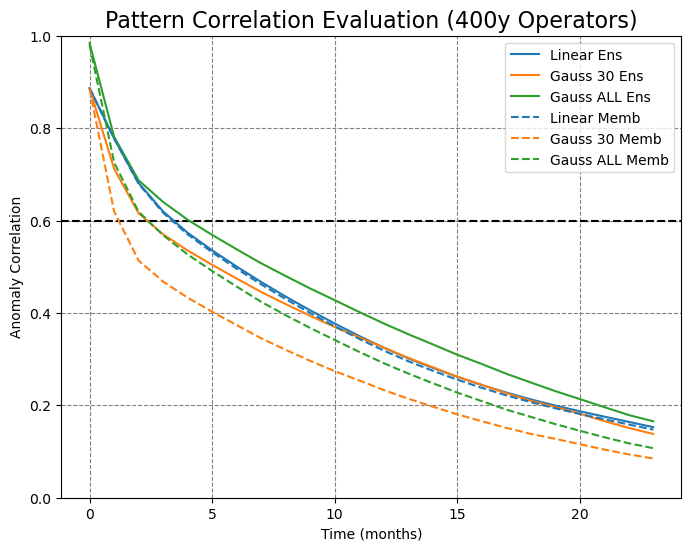

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0,1.0])
ax.set_title('',loc='left')

ax.plot(xval, np.nanmean(Poly_mean, axis=0), lw=1.5, label='Linear Ens')
ax.plot(xval, np.nanmean(Gauss30_mean, axis=0), lw=1.5, label='Gauss 30 Ens')
ax.plot(xval, np.nanmean(GaussALL_mean, axis=0), lw=1.5, label='Gauss ALL Ens')

plt.gca().set_prop_cycle(None)

ax.plot(xval, np.mean(np.nanmean(Poly_ind, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.nanmean(Gauss30_ind, axis=0), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.nanmean(GaussALL_ind, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')


bigtitle = 'Pattern Correlation Evaluation (400y Operators)' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

In [ ]:
Poly_mean=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation.npy')
Gauss30_mean=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation.npy')
GaussALL_mean=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation.npy')

Poly_ind=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation_ind.npy')
Gauss30_ind=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation_ind.npy')
GaussALL_ind=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation_ind.npy')

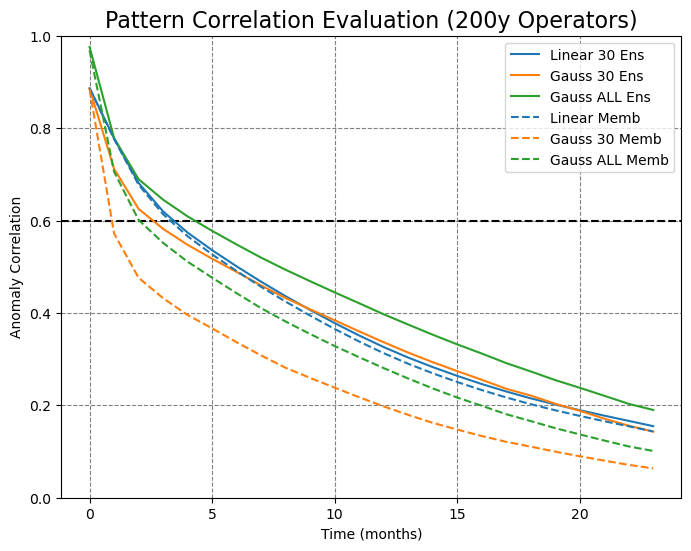

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0,1.0])
ax.set_title('',loc='left')

ax.plot(xval, np.nanmean(Poly_mean, axis=0), lw=1.5, label='Linear 30 Ens')
ax.plot(xval, np.nanmean(Gauss30_mean, axis=0), lw=1.5, label='Gauss 30 Ens')
ax.plot(xval, np.nanmean(GaussALL_mean, axis=0), lw=1.5, label='Gauss ALL Ens')

plt.gca().set_prop_cycle(None)

ax.plot(xval, np.mean(np.nanmean(Poly_ind, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.nanmean(Gauss30_ind, axis=0), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.nanmean(GaussALL_ind, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')


bigtitle = 'Pattern Correlation Evaluation (200y Operators)' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# Old Fig 12

In [5]:
Poly_mean_400=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_400_pattern_correlation.npy')
Gauss30_mean_400=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_400_pattern_correlation.npy')
GaussALL_mean_400=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_400_pattern_correlation.npy')

Poly_ind_400=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_400_pattern_correlation_ind.npy')
Gauss30_ind_400=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_400_pattern_correlation_ind.npy')
GaussALL_ind_400=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_400_pattern_correlation_ind.npy')

In [6]:
Poly_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation.npy')
Gauss30_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation.npy')
GaussALL_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation.npy')

Poly_ind_200=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation_ind.npy')
Gauss30_ind_200=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation_ind.npy')
GaussALL_ind_200=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation_ind.npy')

In [7]:
Poly_mean_100=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_100_pattern_correlation.npy')
Gauss30_mean_100=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_100_pattern_correlation.npy')
GaussALL_mean_100=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation.npy')

Poly_ind_100=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_100_pattern_correlation_ind.npy')
Gauss30_ind_100=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_100_pattern_correlation_ind.npy')
GaussALL_ind_100=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation_ind.npy')

In [8]:
PERSISTENCE=np.load('Other skill metrics/Evaluation correlation of patterns/PERSISTENCE_CORR.npy')

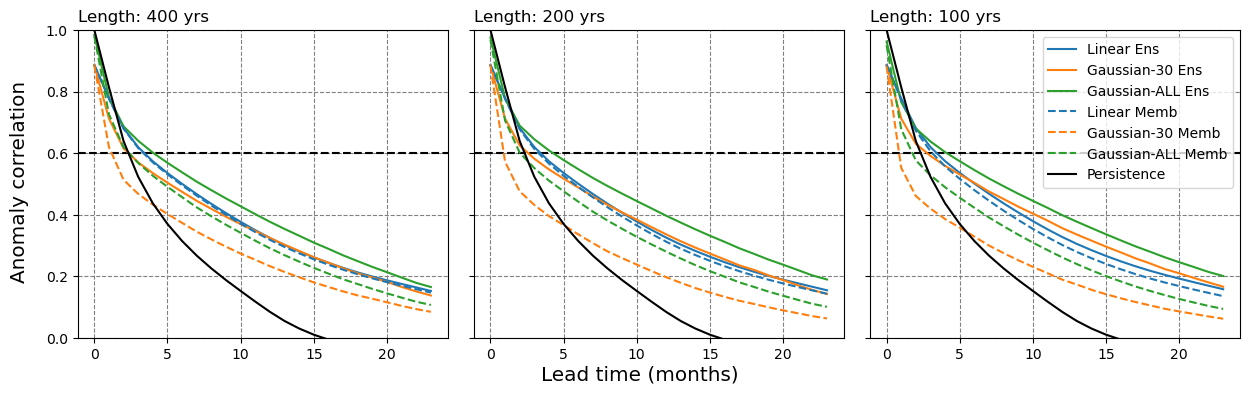

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,4), sharex=True, sharey=True)

xval=range(0,24)

#######   400

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_ylim([0,1.0])
ax[0].set_title('Length: 400 yrs',loc='left')

ax[0].plot(xval, np.nanmean(Poly_mean_400, axis=0), lw=1.5, label='Linear Ens')
ax[0].plot(xval, np.nanmean(Gauss30_mean_400, axis=0), lw=1.5, label='Gauss 30 Ens')
ax[0].plot(xval, np.nanmean(GaussALL_mean_400, axis=0), lw=1.5, label='Gauss ALL Ens')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.nanmean(Poly_ind_400, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.nanmean(Gauss30_ind_400, axis=0), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.nanmean(GaussALL_ind_400, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(PERSISTENCE, axis=0), lw=1.5, label='Persistence', color='black')

ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')


#######   200

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_ylim([0,1.0])
ax[1].set_title('Length: 200 yrs',loc='left')

ax[1].plot(xval, np.nanmean(Poly_mean_200, axis=0), lw=1.5, label='Linear Ens')
ax[1].plot(xval, np.nanmean(Gauss30_mean_200, axis=0), lw=1.5, label='Gauss 30 Ens')
ax[1].plot(xval, np.nanmean(GaussALL_mean_200, axis=0), lw=1.5, label='Gauss ALL Ens')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.nanmean(Poly_ind_200, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(np.nanmean(Gauss30_ind_200, axis=0), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(np.nanmean(GaussALL_ind_200, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(PERSISTENCE, axis=0), lw=1.5, label='Persistence', color='black')

ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')


#######   100

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_ylim([0,1.0])
ax[2].set_title('Length: 100 yrs',loc='left')

ax[2].plot(xval, np.nanmean(Poly_mean_100, axis=0), lw=1.5, label='Linear Ens')
ax[2].plot(xval, np.nanmean(Gauss30_mean_100, axis=0), lw=1.5, label='Gaussian-30 Ens')
ax[2].plot(xval, np.nanmean(GaussALL_mean_100, axis=0), lw=1.5, label='Gaussian-ALL Ens')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.nanmean(Poly_ind_100, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(np.nanmean(Gauss30_ind_100, axis=0), axis=1), lw=1.5, label='Gaussian-30 Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(np.nanmean(GaussALL_ind_100, axis=0), axis=1), lw=1.5, label='Gaussian-ALL Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(PERSISTENCE, axis=0), lw=1.5, label='Persistence', color='black')

ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')

fig.text(0.08, 0.5, 'Anomaly correlation', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.5, 0.005, 'Lead time (months)', ha='center',fontsize='x-large')

plt.subplots_adjust(wspace=0.07)

plt.legend()
plt.suptitle('',fontsize='xx-large')

plt.savefig('Fig 11.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 11.jpg', orientation='landscape',  format='jpg')

plt.show() 

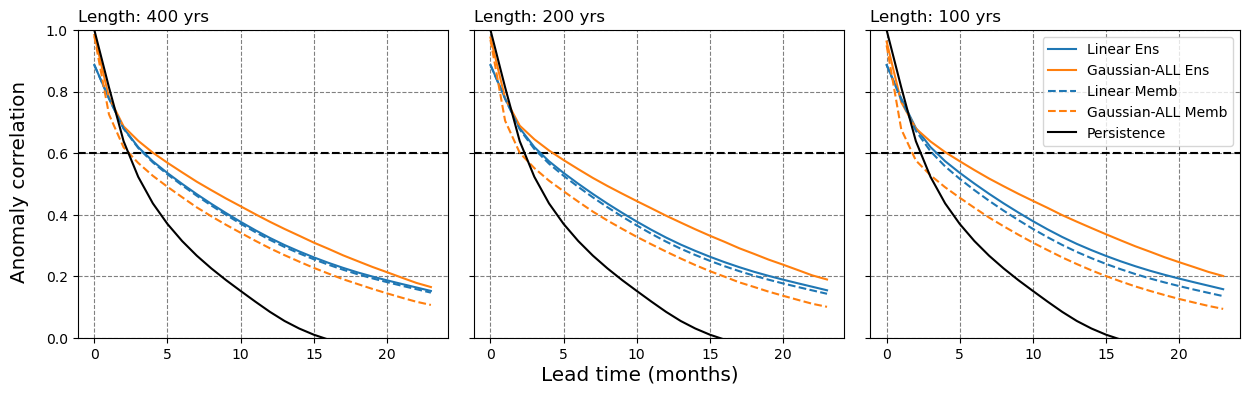

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,4), sharex=True, sharey=True)

xval=range(0,24)

#######   400

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_ylim([0,1.0])
ax[0].set_title('Length: 400 yrs',loc='left')

ax[0].plot(xval, np.nanmean(Poly_mean_400, axis=0), lw=1.5, label='Linear Ens')
ax[0].plot(xval, np.nanmean(GaussALL_mean_400, axis=0), lw=1.5, label='Gauss ALL Ens')
ax[0].set_prop_cycle(None)
ax[0].plot(xval, np.mean(np.nanmean(Poly_ind_400, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(np.nanmean(GaussALL_ind_400, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[0].plot(xval, np.mean(PERSISTENCE, axis=0), lw=1.5, label='Persistence', color='black')

ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')


#######   200

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_ylim([0,1.0])
ax[1].set_title('Length: 200 yrs',loc='left')

ax[1].plot(xval, np.nanmean(Poly_mean_200, axis=0), lw=1.5, label='Linear Ens')
ax[1].plot(xval, np.nanmean(GaussALL_mean_200, axis=0), lw=1.5, label='Gauss ALL Ens')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, np.mean(np.nanmean(Poly_ind_200, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(np.nanmean(GaussALL_ind_200, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')
ax[1].plot(xval, np.mean(PERSISTENCE, axis=0), lw=1.5, label='Persistence', color='black')

ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')


#######   100

ax[2].axhline(0.6, linestyle='--',color='black')
ax[2].set_ylim([0,1.0])
ax[2].set_title('Length: 100 yrs',loc='left')

ax[2].plot(xval, np.nanmean(Poly_mean_100, axis=0), lw=1.5, label='Linear Ens')
ax[2].plot(xval, np.nanmean(GaussALL_mean_100, axis=0), lw=1.5, label='Gaussian-ALL Ens')
ax[2].set_prop_cycle(None)
ax[2].plot(xval, np.mean(np.nanmean(Poly_ind_100, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(np.nanmean(GaussALL_ind_100, axis=0), axis=1), lw=1.5, label='Gaussian-ALL Memb', linestyle='dashed')
ax[2].plot(xval, np.mean(PERSISTENCE, axis=0), lw=1.5, label='Persistence', color='black')

ax[2].yaxis.grid(color='gray', linestyle='dashed')
ax[2].xaxis.grid(color='gray', linestyle='dashed')
ax[2].legend(loc='upper right')

fig.text(0.08, 0.5, 'Anomaly correlation', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.5, 0.005, 'Lead time (months)', ha='center',fontsize='x-large')

plt.subplots_adjust(wspace=0.07)

plt.legend()
plt.suptitle('',fontsize='xx-large')

plt.savefig('Fig 11-bis.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 11-bis.jpg', orientation='landscape',  format='jpg')

plt.show() 

# Fig 7

In [25]:
Poly_mean_400=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_400_pattern_correlation.npy')
Gauss30_mean_400=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_400_pattern_correlation.npy')
GaussALL_mean_400=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_400_pattern_correlation.npy')

Poly_ind_400=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_400_pattern_correlation_ind.npy')
Gauss30_ind_400=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_400_pattern_correlation_ind.npy')
GaussALL_ind_400=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_400_pattern_correlation_ind.npy')

In [26]:
Poly_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation.npy')
Gauss30_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation.npy')
GaussALL_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation.npy')

Poly_ind_200=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation_ind.npy')
Gauss30_ind_200=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_200_pattern_correlation_ind.npy')
GaussALL_ind_200=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation_ind.npy')

In [27]:
Poly_mean_100=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_100_pattern_correlation.npy')
Gauss30_mean_100=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_100_pattern_correlation.npy')
GaussALL_mean_100=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation.npy')

Poly_ind_100=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_100_pattern_correlation_ind.npy')
Gauss30_ind_100=np.load('Other skill metrics/Evaluation correlation of patterns/30GAUSS_100_pattern_correlation_ind.npy')
GaussALL_ind_100=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_100_pattern_correlation_ind.npy')

In [28]:
PERSISTENCE=np.load('Other skill metrics/Evaluation correlation of patterns/PERSISTENCE_CORR.npy')

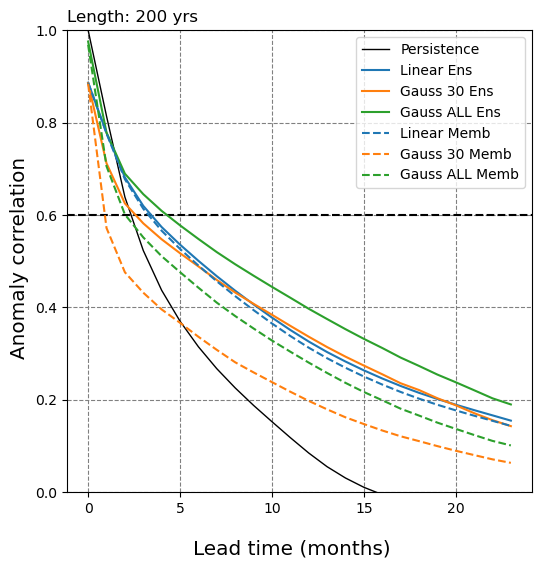

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6), sharex=True, sharey=True)

xval=range(0,24)


#######   200

ax.axhline(0.6, linestyle='--',color='black')
ax.set_ylim([0,1.0])
ax.set_title('Length: 200 yrs',loc='left')

ax.plot(xval, np.mean(PERSISTENCE, axis=0), lw=1, label='Persistence', color='black')

ax.plot(xval, np.nanmean(Poly_mean_200, axis=0), lw=1.5, label='Linear Ens')
ax.plot(xval, np.nanmean(Gauss30_mean_200, axis=0), lw=1.5, label='Gauss 30 Ens')
ax.plot(xval, np.nanmean(GaussALL_mean_200, axis=0), lw=1.5, label='Gauss ALL Ens')
ax.set_prop_cycle(None)
ax.plot(xval, np.mean(np.nanmean(Poly_ind_200, axis=0), axis=1), lw=1.5, label='Linear Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.nanmean(Gauss30_ind_200, axis=0), axis=1), lw=1.5, label='Gauss 30 Memb', linestyle='dashed')
ax.plot(xval, np.mean(np.nanmean(GaussALL_ind_200, axis=0), axis=1), lw=1.5, label='Gauss ALL Memb', linestyle='dashed')

ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

fig.text(0.03, 0.5, 'Anomaly correlation', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.5, 0.007, 'Lead time (months)', ha='center',fontsize='x-large')

plt.subplots_adjust(wspace=0.07)

plt.legend()
plt.suptitle('',fontsize='xx-large')

plt.savefig('Fig 7.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 7.jpg', orientation='landscape',  format='jpg')

plt.show() 

# Spatial correlation strong El niño cases

In [26]:
## Compute observations NON truncated to PCs
Xindex=X_tos.A.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))#[:-1]
Xindex

<xarray.DataArray (time: 24000)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.9016017 ,
       -0.9271781 , -0.89309406], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [27]:
threshold = np.percentile(Xindex, 90) # calculate the 10th percentile
print(threshold)
mask=Xindex>=threshold

1.1912627816200263


### ALL GAUSS

### Prepare data

In [81]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [82]:
tot_for=np.zeros((20, 17, 1845, 24, 1176))

In [83]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

In [84]:
tot_for_union=np.empty((17, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [85]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [86]:
del(tot_for)

In [87]:
tot_for_union.shape

(17, 1845, 24, 24000)

In [88]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [ ]:
#NIÑ0
threshold = np.percentile(Xindex[0:23977], 90) # calculate the 10th percentile      90 for Niño     10 for niña
print(threshold)
mask=Xindex[0:23977]>=threshold

In [112]:
#NIÑA
threshold = np.percentile(Xindex[0:23977], 10) # calculate the 10th percentile      90 for Niño     10 for niña
print(threshold)
mask=Xindex[0:23977]<=threshold

-1.2503053665161132


In [114]:
cases=np.where(mask)[0]

In [115]:
mean_av=np.zeros((len(cases),24))

In [116]:
cases.shape

(2398,)

In [117]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,len(cases)):
        init=cases[l]
    
        av_for_geo_array=udat_sst @ av_for[0:845,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        
    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead]) 

0    0.9768863013523359
1    0.8694666882532892
2    0.8303011349639292
3    0.8094090031718363
4    0.7893863996891328
5    0.7664584823949775
6    0.7385214240415153
7    0.7080621049953001
8    0.6728085494225201
9    0.6369452355706375
10    0.6011638981534949
11    0.5642622583579264
12    0.5285299363873776
13    0.4940217320072632
14    0.4620901364197718
15    0.43311822157929875
16    0.40361245565656295
17    0.3762762318796719
18    0.35105087326848466
19    0.3294163227656662
20    0.3107745907173453
21    0.2950510314367529
22    0.28045740081079
23    0.2625479038368567


In [118]:
np.save('Other skill metrics/Evaluation correlation of patterns/NIÑA10_ALLGAUSS_200_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)

### POLY

### Prepare data

In [119]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [120]:
tot_for=np.zeros((20, 17, 30, 24, 1176))

In [121]:
for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/POLY_forecast_p{n}.npy')

In [122]:
tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [123]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [124]:
del(tot_for)

In [125]:
tot_for_union.shape

(17, 30, 24, 24000)

In [126]:
tot_for_union=tot_for_union[[0,2,4,6,8,10,12,14,16],:,:,:]
#compute averaged forecast
av_for=np.mean(tot_for_union, axis=0)

### Evaluation

In [68]:
#NIÑO
threshold = np.percentile(Xindex, 90) # calculate the 10th percentile
print(threshold)
mask=Xindex>=threshold

1.1912627816200263


In [127]:
#NIÑA
threshold = np.percentile(Xindex[0:23977], 10) # calculate the 10th percentile      90 for Niño     10 for niña
print(threshold)
mask=Xindex[0:23977]<=threshold

-1.2503053665161132


In [128]:
cases=np.where(mask)[0]

In [129]:
mean_av=np.zeros((len(cases),24))

In [130]:
cases

array([   21,    22,    23, ..., 23911, 23939, 23940])

In [131]:
#for n in lead_times:
for lead in range(0,24):

    for l in range(0,len(cases)):
        init=cases[l]
    
        av_for_geo_array=udat_sst @ av_for[0:20,lead,init+lead]            
        av_for_geo = xr.full_like(X_tos.A[:,init+lead],0)
        av_for_geo.data=av_for_geo_array.real
        
        #Correlation average forecast and observations
        mean_av[l,lead]=np.corrcoef(av_for_geo,X_tos.A.isel(time=init+lead))[0,1]
 
        
    print(lead, "  ", np.nanmean(mean_av, axis=0)[lead]) 

0    0.9286583462985927
1    0.8702907672273361
2    0.8164528466382872
3    0.7804983381498614
4    0.750863671351484
5    0.7199556150354188
6    0.684096508029859
7    0.6456685283168
8    0.6033793537772587
9    0.5585708802884095
10    0.5151318301448194
11    0.4731432545777732
12    0.43697382634073184
13    0.40590615615142905
14    0.3772985892653187
15    0.3502321971360247
16    0.3225201665497567
17    0.29582924149496165
18    0.2739675001952539
19    0.25556941889077783
20    0.2388284442266436
21    0.22223478270936223
22    0.20648241744668372
23    0.18831223371690864


In [132]:
np.save('Other skill metrics/Evaluation correlation of patterns/NIÑA10_POLY_200_pattern_correlation', mean_av, allow_pickle=True, fix_imports=True)

### Plot

In [136]:
Poly_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/POLY_200_pattern_correlation.npy')
GaussALL_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/ALLGAUSS_200_pattern_correlation.npy')

NIÑO10_Poly_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/NIÑO10_POLY_200_pattern_correlation.npy')
NIÑO10_GaussALL_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/NIÑO10_ALLGAUSS_200_pattern_correlation.npy')

NIÑA10_Poly_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/NIÑA10_POLY_200_pattern_correlation.npy')
NIÑA10_GaussALL_mean_200=np.load('Other skill metrics/Evaluation correlation of patterns/NIÑA10_ALLGAUSS_200_pattern_correlation.npy')


PERSISTENCE=np.load('Other skill metrics/Evaluation correlation of patterns/PERSISTENCE_CORR.npy')

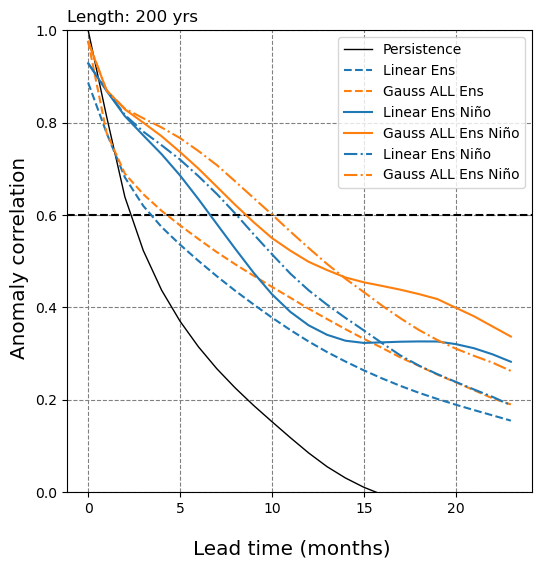

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6), sharex=True, sharey=True)

xval=range(0,24)


#######   200

ax.axhline(0.6, linestyle='--',color='black')
ax.set_ylim([0,1.0])
ax.set_title('Length: 200 yrs',loc='left')

ax.plot(xval, np.mean(PERSISTENCE, axis=0), lw=1, label='Persistence', color='black')

ax.plot(xval, np.nanmean(Poly_mean_200, axis=0), lw=1.5, label='Linear Ens', linestyle='dashed')
ax.plot(xval, np.nanmean(GaussALL_mean_200, axis=0), lw=1.5, label='Gauss ALL Ens', linestyle='dashed')
ax.set_prop_cycle(None)
ax.plot(xval, np.nanmean(NIÑO10_Poly_mean_200, axis=0), lw=1.5, label='Linear Ens Niño')
ax.plot(xval, np.nanmean(NIÑO10_GaussALL_mean_200, axis=0), lw=1.5, label='Gauss ALL Ens Niño')
ax.set_prop_cycle(None)
ax.plot(xval, np.nanmean(NIÑA10_Poly_mean_200, axis=0), lw=1.5, label='Linear Ens Niño', linestyle='dashdot')
ax.plot(xval, np.nanmean(NIÑA10_GaussALL_mean_200, axis=0), lw=1.5, label='Gauss ALL Ens Niño', linestyle='dashdot')


ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

fig.text(0.03, 0.5, 'Anomaly correlation', va='center', rotation='vertical',fontsize='x-large')
fig.text(0.5, 0.007, 'Lead time (months)', ha='center',fontsize='x-large')

plt.subplots_adjust(wspace=0.07)

plt.legend()
plt.suptitle('',fontsize='xx-large')

#plt.savefig('Fig 8.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 8.jpg', orientation='landscape',  format='jpg')

plt.show() 